In [17]:
#Import libraries
import data_preprocessing as pre
import global_vals as global_vals
import csv
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_acc_roll_angle(acc_y, acc_z):
    """
    returns roll angle
    """
    return np.degrees(np.arctan(acc_y / acc_z))

def get_acc_pitch_angle(acc_x, acc_y, acc_z):
    """"
    Return Pitch angle
    """
    denominator = np.sqrt(np.power(acc_y, 2) + np.power(acc_z, 2))
    pitch_angle = np.degrees(np.arctan(((-1) * acc_x) / denominator))
    return pitch_angle

In [4]:
#Data Pre Processing
path = r'C:/Users/Mohit.Nagpal/Desktop/driverBehaviourAnalysis-master/Trip data'
# Extract all files extension is .csv
files = glob.glob(os.path.join(path, "*.csv"))
#files = files[0:11]
data = []
for csv in files:
    header = ['time_vector(s)','rpm','speed(kmph)','engine_load','acc_x(G)','acc_y(G)','acc_z(G)','gyro_x(rad_per_s)','gyro_y(rad_per_s)','gyro_z(rad_per_s)','mag_x','mag_y','mag_z']   
    frame = pd.read_csv(csv,names=header)
    frame['date'] = os.path.basename(csv)
    data.append(frame)

In [5]:
df = pd.concat(data, ignore_index=True)
df['date'] =df['date'].apply(lambda x : x.split(".")[0].replace("_","-"))
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d-%H-%M-%S')
df = df[df['speed(kmph)'] > 0 ]  #when vehicle is moving
df.reset_index(drop=True, inplace=True)

In [6]:
df['speed(kmph)'].value_counts()

45     1812
44     1746
43     1736
1      1706
41     1647
42     1574
35     1528
40     1517
26     1498
29     1495
46     1493
33     1482
19     1465
21     1462
23     1460
39     1452
38     1451
34     1450
30     1441
28     1437
24     1432
2      1427
32     1426
31     1422
20     1417
27     1411
17     1407
3      1401
37     1400
5      1399
       ... 
91      168
102     167
88      165
80      162
95      159
94      158
89      157
79      156
97      155
87      153
108     153
99      149
110     144
96      143
107     143
81      140
98      139
83      135
104     131
101     130
86      122
109     121
82      120
111     120
85      116
84      107
112      77
113      54
114      11
115       6
Name: speed(kmph), Length: 115, dtype: int64

In [7]:
ac = []
gy = []
for i in range(0, len(df)):
    a = max(df['acc_x(G)'][i] , df['acc_y(G)'][i] , df['acc_z(G)'][i])
    b = max(df['gyro_x(rad_per_s)'][i], df['gyro_y(rad_per_s)'][i], df['gyro_z(rad_per_s)'][i])
    ac.append(a)
    gy.append(b)

df['acc'] = ac
df['gyro'] = gy
df['accX_ms'] = df['acc_x(G)'] * 9.807
df['accY_ms'] = df['acc_y(G)'] * 9.807
df['accZ_ms'] = df['acc_z(G)'] * 9.807
df['gyroX_dps'] = df['gyro_x(rad_per_s)'] * 57.296
df['gyroY_dps'] = df['gyro_y(rad_per_s)'] * 57.296
df['gyroZ_dps'] = df['gyro_z(rad_per_s)'] * 57.296
df['acc_ms'] = df['acc']  * 9.807
df['gyro_dps'] = df['gyro'] * 57.296
df['speed_mps'] = df['speed(kmph)'] *0.278
df['acc_roll_angle'] = get_acc_roll_angle(df['accY_ms'], df['accZ_ms'])
df['acc_pitch_angle'] = get_acc_pitch_angle(df['accX_ms'], df['accY_ms'], df['accZ_ms'])
df1 = df[['date','speed_mps', 'acc_ms', 'gyro_dps', 'acc_roll_angle', 'acc_pitch_angle']]
df1.to_csv(r"C:/Users/Mohit.Nagpal/Desktop/driverBehaviourAnalysis-master/ProcessedData/processed_data.csv", index=False) #saving in csv

In [11]:
class Driver:
    
    def __init__(self):
        #preprocess = pre.data_preprocess()
        self.dataset = df1
        self.file_init = False
        self.file_name = 'feature_outputs/'
        
    def get_dataset(self):
        return self.dataset
    
    def generate_features_csv(self,feature_vector,row_count):
        if(self.file_init == False):
            self.file_name += "driver_features.csv"
            self.file_init = True
            header = ['index','max_speed','max_rotation','max_acc','avg_acc','avg_rotation','avg_speed','min_acc','min_speed','min_rotation','acc_roll_angle', 'acc_pitch_angle']
            with open(self.file_name, 'w') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(header)
            writeFile.close()
        else:
            feature_vector = list(feature_vector.values())
            feature_vector = [row_count]+feature_vector
            with open(self.file_name, 'a') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(feature_vector)
            writeFile.close()
    
    def write_features(self,feature_vector,row_count):
        if(self.file_init == False):
            self.file_name += "driver_features.csv"
            self.file_init = True
            header = ['index','max_speed','max_rotation','max_acc','avg_acc','avg_rotation','avg_speed','min_acc','min_speed','min_rotation','acc_roll_angle', 'acc_pitch_angle','score']
            with open(self.file_name, 'w') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(header)
            writeFile.close()
        else:
            score = 10.0
            if (feature_vector['max_speed'] > 10.5):
                score = score - 1.3
            elif (feature_vector['max_speed'] >12.5):
                score = score - 2.9
            elif (feature_vector['max_speed'] > 15.0): 
                score = score - 5.7
            if (feature_vector['avg_speed'] >10.5):
                score = score - 1.5
            #no need for other speed conditions since max conditions covers them
            if (feature_vector['max_rotation'] >0.1):
                score = score - 0.5
            elif (feature_vector['max_rotation'] >0.8):
                score = score - 0.8
            if (feature_vector['avg_rotation'] >0.1):
                score = score - 0.6
            if (feature_vector['max_acc'] >1.5 and feature_vector['max_acc'] <2.0):
                score = score - 1.8
            elif (feature_vector['max_acc'] >1.0 and feature_vector['max_acc'] <2.0):
                score = score - 1.0
            if (feature_vector['avg_acc'] >1.0):
                score = score - 0.4
            feature_vector = list(feature_vector.values())
            feature_vector = [row_count]+feature_vector+[score]
            with open(self.file_name, 'a') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(feature_vector)
            writeFile.close()
            

    
    def generate_feature_vectors(self):
        self.data_rows = self.dataset.iloc[:,:-1].values.tolist()
        self.feature_vector = {}
        speed = self.dataset['speed_mps'].values
        acc = self.dataset['acc_ms'].values
        gyro = self.dataset['gyro_dps'].values
        acc_roll_angle = self.dataset['acc_roll_angle'].values
        acc_pitch_angle = self.dataset['acc_pitch_angle'].values
        print(len(self.data_rows))
        for row_count in range(len(self.data_rows)):
            feature_element = {}
            max_speed = 0
            min_speed = 999
            avg_speed = 0
            max_acc = 0
            min_acc =999
            avg_acc = 0
            max_rotation = 0
            min_rotation = 999
            avg_rotation = 0
            count=0
            if (row_count+global_vals.sample_size>len(self.data_rows)):
                global_vals.sample_size = global_vals.sample_size - row_count - 1
            while count in range(global_vals.sample_size):
                max_speed = abs(speed[row_count+count]) if abs(speed[row_count+count])>max_speed else max_speed
                max_rotation = abs(gyro[row_count+count]) if abs(gyro[row_count+count])>max_rotation else max_rotation
                max_acc = abs(acc[row_count+count]) if abs(acc[row_count+count])>max_acc else max_acc
                acc_roll = acc_roll_angle[row_count+count]
                acc_pitch = acc_pitch_angle[row_count+count]

                avg_speed+=abs(speed[row_count+count])
                avg_acc+=abs(acc[row_count+count])
                avg_rotation+=abs(gyro[row_count+count])
                
                min_speed = abs(speed[row_count+count]) if abs(speed[row_count+count])<min_speed else min_speed
                min_rotation = abs(gyro[row_count+count]) if abs(gyro[row_count+count])<min_rotation else min_rotation
                min_acc = abs(acc[row_count+count]) if abs(acc[row_count+count])<min_acc else min_acc
                count+=1
            
            if(count>0):
                avg_acc/=global_vals.sample_size
                avg_speed/=global_vals.sample_size
                avg_rotation/=global_vals.sample_size
                
                feature_element['max_speed'] = max_speed
                feature_element['max_rotation'] = max_rotation
                feature_element['max_acc'] = max_acc
                feature_element['avg_acc'] = avg_acc
                feature_element['avg_rotation'] = avg_rotation
                feature_element['avg_speed'] = avg_speed
                feature_element['min_acc'] = min_acc
                feature_element['min_speed'] = min_speed
                feature_element['min_rotation'] = min_rotation
                feature_element['acc_roll_angle'] = acc_roll
                feature_element['acc_pitch_angle'] = acc_pitch
                
                
                if global_vals.train_mode == True:
                    self.write_features(feature_element,row_count)
                else:
                    self.generate_features_csv(feature_element,row_count)
                
                
                self.feature_vector[row_count] = feature_element

        return self.feature_vector

In [18]:
Driver_obj = Driver()
feature_dict = Driver_obj.generate_feature_vectors()

91610


In [31]:
df2 = pd.read_csv(r'C:/Users/Mohit.Nagpal/Desktop/driverBehaviourAnalysis-master/feature_outputs/driver_features.csv')
df2 = df2.drop(['index'], axis=1)

In [32]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [33]:
#Modeling
X = df2.iloc[:, :11].values
y = df2.iloc[:, 11].values

for count in range(0,len(y)):
    if y[count] <7.5:
        y[count]=0
    else:
        y[count]=1

In [34]:
df2['score'].value_counts()

0.0    52357
1.0    39243
Name: score, dtype: int64

In [45]:
#Modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(len(X_train)),print(len(y_train)),print(len(X_test)),print(len(y_test))
lreg = LogisticRegression()
lreg.fit(X_train, y_train)
print(lreg.coef_)
print(lreg.intercept_)
y_pred = lr.predict(X_test)
tn,fp,fn,tp=confusion_matrix(y_test, y_pred).ravel()
print("True Negatives:",tn)
print("True Positives:",tp)
print("False Negatives:",fn)
print("False Positives :",fp)

73280
73280
18320
18320
[[-0.21043532  0.01601276  0.0029511  -0.26991365 -0.03050165 -0.09666001
  -0.69853391 -0.16171271 -0.04630147  0.0086305  -0.00290166]]
[4.02770369]
True Negatives: 8898
True Positives: 6429
False Negatives: 1535
False Positives : 1458


In [42]:
#Accuracy of the model
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_pred)
score

0.8366266375545851

In [54]:
# Accuracy using Formulas
Accuracy= (tp+tn)/(tp+tn+fp+fn)
Precision=tp/(tp+fp)
Recall=tp/(tp+fn)
Specificity=tn/(tn+fp)
Sensitivity=tp/(fn+tp)
print("Accuracy{:0.2f}".format(Accuracy))
print("Precision{:0.2f}".format(Precision))
print("Recall{:0.2f}".format(Recall))
print("Specificity{:0.2f}".format(Specificity))
print("Sensitivity{:0.2f}".format(Sensitivity)) # Recall= Sensitivity

Accuracy0.84
Precision0.82
Recall0.81
Specificity0.86
Sensitivity0.81


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86     10356
         1.0       0.82      0.81      0.81      7964

   micro avg       0.84      0.84      0.84     18320
   macro avg       0.83      0.83      0.83     18320
weighted avg       0.84      0.84      0.84     18320



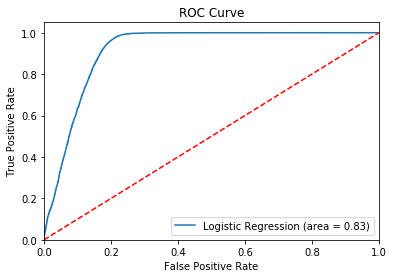

In [56]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()